In [1]:
%load_ext autoreload

%autoreload 2


In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Load data

In [1]:
from preprocess import preprocess, compute_dataset_statistics, save_data
from tools import read_yaml_config

config_file_path = 'configs/config_kate.yaml'
species = 'giraffe_rm'
config = read_yaml_config(config_file_path, species)
print(config)

anno_path = config["preprocessed_annotation_path"]


images_dir = config["images_dir"]
csv_dir = config['csv_dir']
csv_column_names = config['csv_column_names']
merge_cols = config['merge_cols']
output_path = config['preprocessed_annotation_path']

data=preprocess(anno_path, images_dir, csv_dir, csv_column_names, merge_cols)
compute_dataset_statistics(data)


{'data_dir': '/home/kate/data/coco_giraffe', 'export_dir': '/home/kate/data/coco_giraffe/split', 'images_dir': '/home/kate/data/coco_giraffe/tamil/coco/images/test2023/', 'raw_annotation_path': '/home/kate/data/coco_giraffe/export_annotations_encounters/instances_train2023.json', 'raw_annotation_path_test': '/home/kate/data/coco_giraffe/export_annotations_encounters/instances_test2024.json', 'raw_annotation_path_val': '/home/kate/data/coco_giraffe/export_annotations_encounters/instances_val2024.json', 'preprocessed_annotation_path': '/home/kate/data/coco_giraffe/preprocessed/giraffe_flipped.json', 'excluded_viewpoints': ['front'], 'csv_dir': 'None', 'csv_column_names': 'None', 'merge_cols': 'None'}
Merging on image uuid


KeyError: 'name'

In [27]:
data = data[data['species'] == 'zebra_plains']
compute_dataset_statistics(data)


Dataset Statistics:
Number of annotations: 6286
Number of images: 4405
Number of individuals: 1905
Number of individual viewpoints: 2262
Number of categories: 1
Number of singletons: 1197

Annotations per Viewpoint:
back: 63
backleft: 431
backright: 29
front: 41
frontleft: 410
frontright: 42
left: 5062
right: 208

Max images per name: 28
Min images per name: 1
Average images per name: 3.30
Average images per name_viewpoint: 2.78


In [36]:
# Run this if you have 3 input jsons
import pandas as pd
from preprocess import preprocess, compute_dataset_statistics, save_data
from tools import read_yaml_config

config_file_path = 'configs/config_kate.yaml'
species = 'zebra_plain'
config = read_yaml_config(config_file_path, species)
print(config)

anno_path_train = config["raw_annotation_path"]
anno_path_test = config["raw_annotation_path_test"]
anno_path_val = config["raw_annotation_path_val"]

images_dir = config["images_dir"]
csv_dir = config['csv_dir']
csv_column_names = config['csv_column_names']
merge_cols = config['merge_cols']
output_path = config['preprocessed_annotation_path']

print('TRAIN')
data_train=preprocess(anno_path_train, images_dir, csv_dir, csv_column_names, merge_cols)
compute_dataset_statistics(data_train)


print('TEST')
data_test=preprocess(anno_path_test, images_dir, csv_dir, csv_column_names, merge_cols)
compute_dataset_statistics(data_test)


print('VAL')

data_val=preprocess(anno_path_val, images_dir, csv_dir, csv_column_names, merge_cols)
compute_dataset_statistics(data_val)

# data =  pd.concat([data_train, data_val, data_test])
data = pd.concat([data_val, data_test])

{'data_dir': '/home/kate/data/plainZebra_giraffeID/gzgc.coco', 'export_dir': '/home/kate/data/plainZebra_giraffeID/gzgc.coco/annotations/split', 'images_dir': '/home/kate/data/plainZebra_giraffeID/gzgc.coco/images/train2020', 'raw_annotation_path': '/home/kate/data/plainZebra_giraffeID/gzgc.coco/annotations/split/instances_train2024.json', 'raw_annotation_path_test': '/home/kate/data/plainZebra_giraffeID/gzgc.coco/annotations/split/instances_test2024.json', 'raw_annotation_path_val': '/home/kate/data/plainZebra_giraffeID/gzgc.coco/annotations/split/instances_val2024.json', 'preprocessed_annotation_path': '/home/kate/data/plainZebra_giraffeID/gzgc.coco/annotations/preprocessed/plain_zebra_miewid_singletons_encounters.json', 'excluded_viewpoints': ['back', 'backleft', 'bckright', 'front', 'frontleft', 'frontright'], 'csv_dir': 'None', 'csv_column_names': 'None', 'merge_cols': 'None'}
TRAIN
Merging on image uuid
Dataset Statistics:
Number of annotations: 3015
Number of images: 2323
Number

In [37]:
df=data

In [41]:
# data['name_viewpoint'] = data['name'] + '-' + data['viewpoint']

annotation_counts = df['name_viewpoint'].value_counts()
single_annotation_count = (annotation_counts == 1).sum()

print(f" ---- number of singletons: {single_annotation_count}")

counts = df.groupby('viewpoint').size()
print(counts)


 ---- number of singletons: 416
viewpoint
left     914
right     43
dtype: int64


In [40]:
df = encounters_df

In [39]:
def remove_close_annotations(df, time_column='datetime_captured', group_column='name_viewpoint', time_threshold=30):
    # Convert date_captured column to datetime
    df[time_column] = pd.to_datetime(df['date_captured'], errors='coerce')
    
    # Sort the dataframe by time within each group to make sure we keep the first annotation
    df = df.sort_values(by=[group_column, time_column])
    
    # Initialize an empty list to store indices of rows to keep
    indices_to_keep = []

    # Group by name_viewpoint
    grouped = df.groupby(group_column)
    
    for _, group in grouped:
        # Iterate through sorted group and keep only the first annotation within 30-minute windows
        last_kept_time = None
        # print(group)
        for i, row in group.iterrows():
            # print(i)

            if row[time_column]=='NA':
                indices_to_keep.append(i)

            elif last_kept_time is None or (row[time_column] - last_kept_time).total_seconds() >= time_threshold * 60:
                indices_to_keep.append(i)
                last_kept_time = row[time_column]
    print(indices_to_keep)
    # Filter the dataframe to keep only the selected rows
    filtered_df = df.loc[indices_to_keep]
    
    return filtered_df

df = df.reset_index()
# Example usage
encounters_df = remove_close_annotations(df, 'datetime_captured', 'name_viewpoint', 5)

[1277, 1304, 512, 649, 482, 487, 515, 1274, 1416, 496, 524, 486, 513, 498, 1297, 1080, 1302, 1308, 1287, 1310, 832, 810, 479, 511, 359, 1275, 1290, 1272, 981, 1119, 183, 335, 504, 276, 1279, 520, 1311, 1076, 483, 356, 497, 523, 509, 526, 1295, 1312, 1270, 1305, 491, 62, 1292, 1315, 527, 1316, 529, 1320, 1061, 531, 1321, 572, 750, 578, 534, 1364, 1374, 571, 382, 1372, 1365, 1371, 539, 765, 1368, 1324, 1332, 968, 540, 764, 257, 1336, 1008, 543, 691, 1340, 1423, 547, 545, 637, 1327, 1247, 1188, 579, 1343, 1326, 569, 749, 573, 548, 168, 1342, 1454, 554, 786, 1357, 855, 1360, 1527, 557, 792, 1351, 559, 556, 1349, 570, 748, 1355, 1566, 1334, 1362, 1346, 1262, 558, 1348, 1562, 1353, 1359, 562, 50, 577, 86, 568, 48, 542, 45, 533, 1330, 1338, 1511, 536, 552, 899, 1021, 1475, 584, 604, 1288, 1385, 1296, 1313, 1381, 489, 518, 1392, 1380, 1394, 1384, 607, 591, 600, 598, 582, 493, 519, 589, 505, 282, 602, 583, 213, 503, 525, 1286, 1155, 1390, 1379, 603, 588, 1387, 500, 484, 1268, 506, 1281, 1307, 1

(290.0390625, 310.546875, 1409.1796875, 1057.6171875)


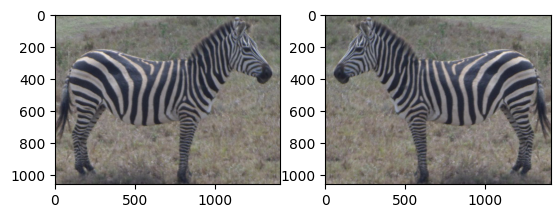

000000003611__xflipped.jpg
(1026.3157894736844, 584.0311004784688, 425.2392344497608, 244.91626794258372)


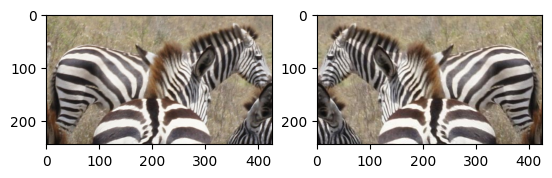

000000003689__xflipped.jpg
(1322.3684210526317, 418.0622009569378, 714.1148325358852, 324.7607655502392)


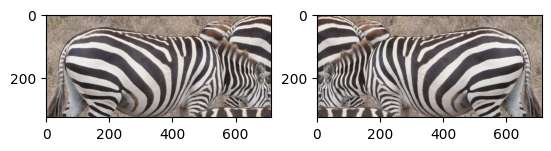

000000003843__xflipped.jpg
(915.0717703349283, 436.0047846889952, 521.2320574162679, 224.28229665071768)


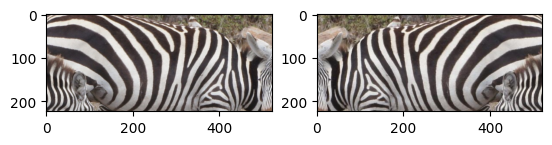

000000003843__xflipped.jpg
(591.2081339712918, 999.4019138755981, 488.9354066985646, 412.67942583732054)


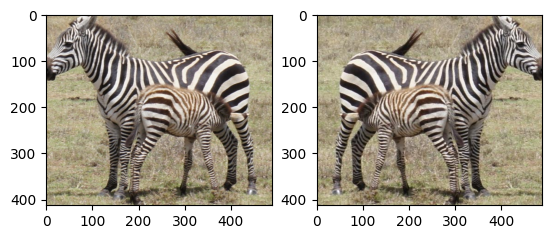

000000003772__xflipped.jpg
(1584.9719101123594, 552.6685393258427, 970.5056179775281, 645.3651685393259)


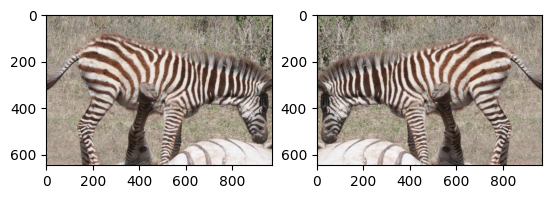

000000004427__xflipped.jpg
(206.46067415730295, 397.4719101123596, 2089.185393258427, 1392.556179775281)


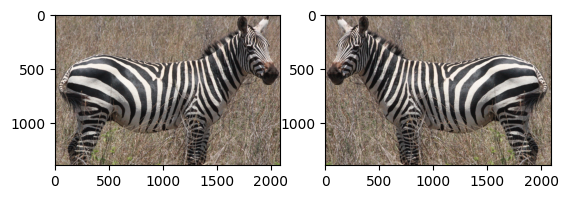

000000004231__xflipped.jpg
(1099.7191011235955, 673.4550561797753, 629.9157303370787, 357.4438202247191)


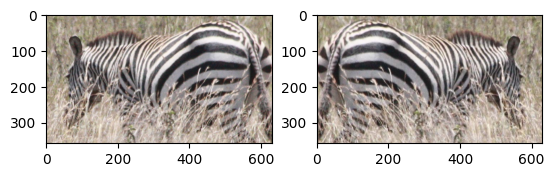

000000004648__xflipped.jpg
(883.0, 454.0, 1427.0, 960.0)


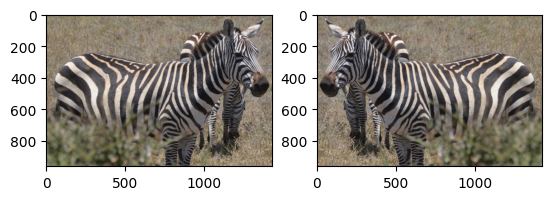

000000002011__xflipped.jpg
(579.0, 818.5, 467.0, 334.0)


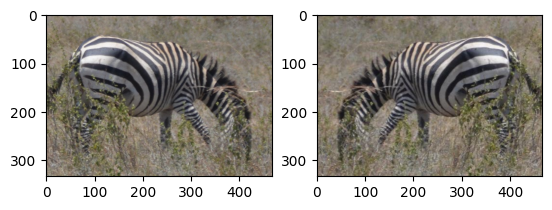

000000002008__xflipped.jpg
(527.5, 827.0, 402.5, 278.5)


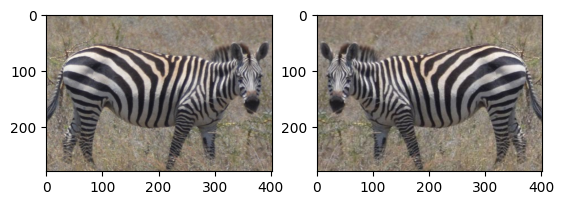

000000001999__xflipped.jpg
(720.0, 882.5, 570.0, 445.5)


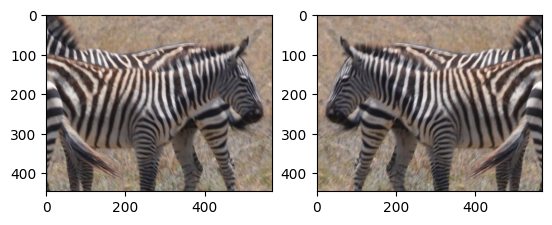

000000001969__xflipped.jpg
(214.5, 651.0, 810.0, 510.0)


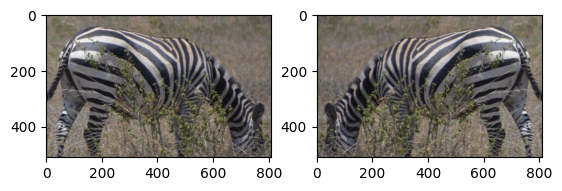

000000002004__xflipped.jpg
(930.0, 141.0, 360.0, 265.5)


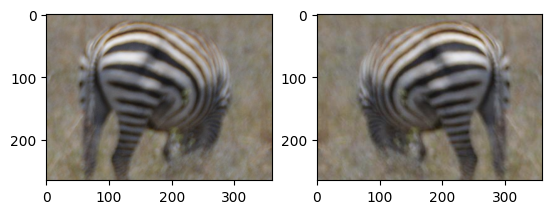

000000002011__xflipped.jpg
(2165.0, 355.5, 822.5, 497.0)


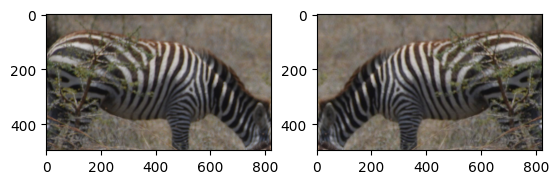

000000002006__xflipped.jpg
(2152.0, 510.0, 291.0, 192.5)


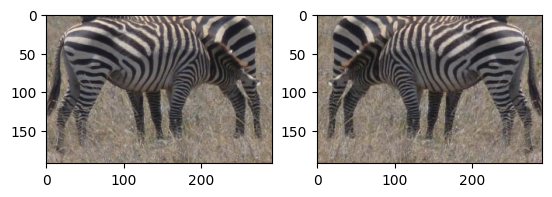

000000001993__xflipped.jpg
(1513.5, 428.25, 1088.25, 856.5)


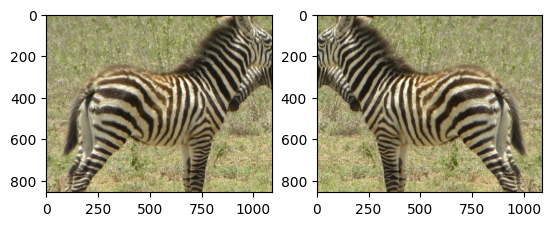

000000001961__xflipped.jpg
(523.5, 240.0, 2386.5, 1410.0)


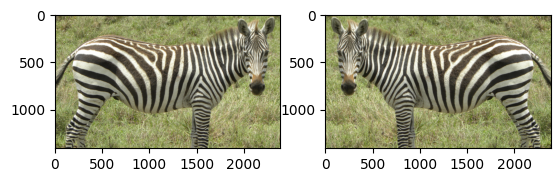

000000001881__xflipped.jpg
(1101.5625, 333.984375, 1448.5677083333333, 1049.4791666666665)


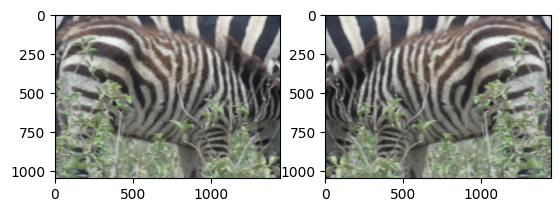

000000001834__xflipped.jpg
(176.25, 385.5, 2370.0, 1230.0)


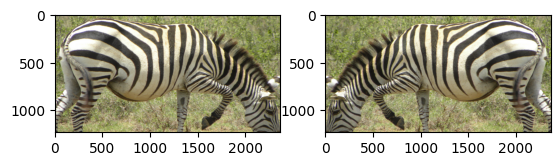

000000001958__xflipped.jpg
(1663.5, 826.5, 856.5, 393.75)


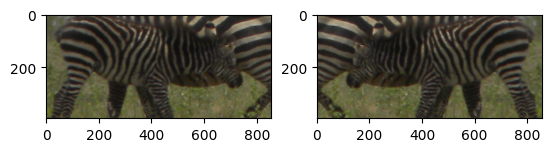

000000001722__xflipped.jpg
(982.5, 210.0, 1936.5, 1173.75)


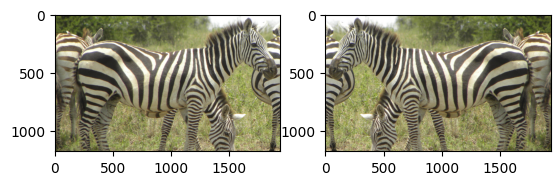

000000001910__xflipped.jpg
(1157.638888888889, 740.9722222222222, 942.3611111111111, 916.6666666666666)


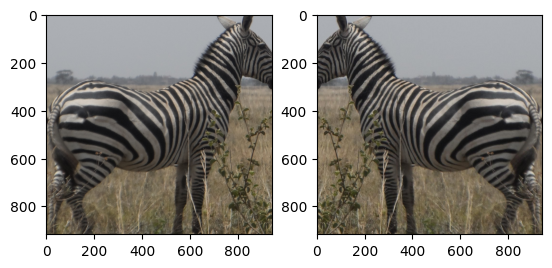

000000003123__xflipped.jpg
(60.416666666666515, 1212.5, 702.7777777777777, 518.0555555555555)


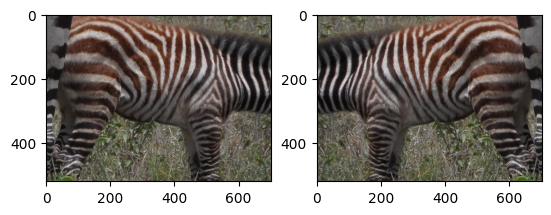

000000003194__xflipped.jpg
(926.3888888888887, 1011.1111111111111, 278.47222222222223, 192.36111111111111)


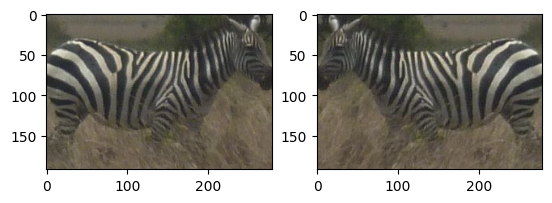

000000003453__xflipped.jpg
(193.75, 663.8888888888889, 1932.638888888889, 997.9166666666666)


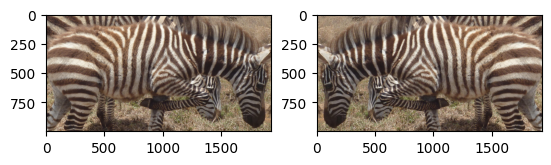

000000003459__xflipped.jpg
(2323.5, 874.0, 402.5, 308.5)


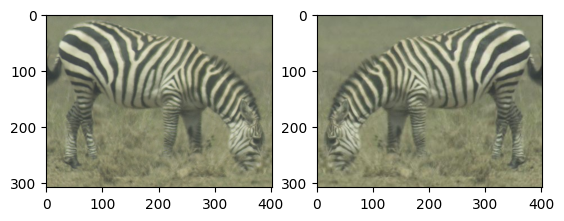

000000000258__xflipped.jpg
(1714.5, 857.0, 908.5, 591.0)


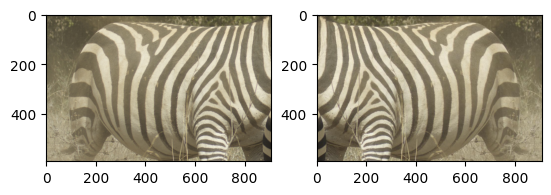

000000000310__xflipped.jpg
(1676.0, 1071.0, 227.0, 218.5)


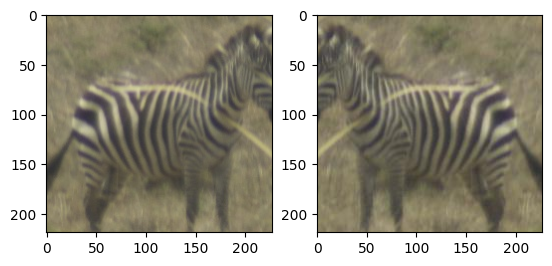

000000000254__xflipped.jpg
(2503.125, 654.6875, 282.8125, 187.5)


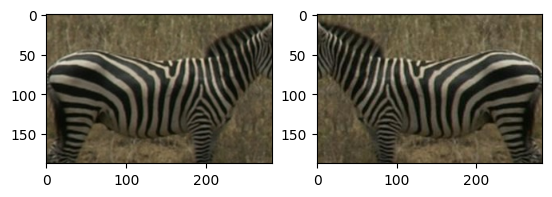

000000000733__xflipped.jpg
(1475.6493506493507, 821.8344155844155, 1151.7857142857142, 668.4253246753246)


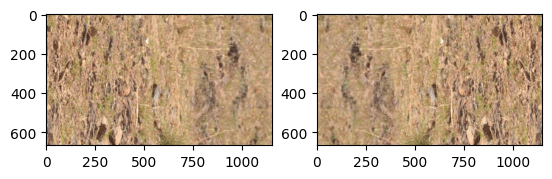

000000001329__xflipped.jpg
(253.51123595505624, 59.69101123595506, 552.6685393258427, 367.97752808988764)


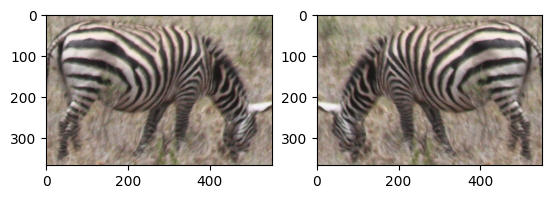

000000000984__xflipped.jpg
(1479.1666666666667, 750.0, 329.4270833333333, 274.08854166666663)


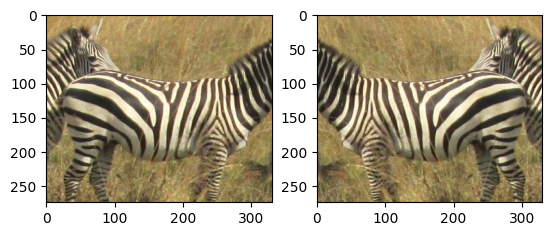

000000000412__xflipped.jpg
(1342.0138888888887, 865.1620370370371, 479.7453703703704, 282.4074074074074)


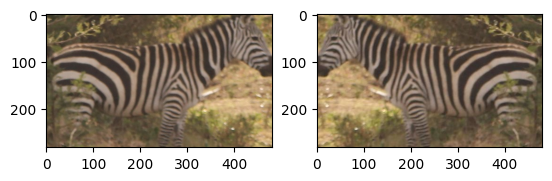

000000000385__xflipped.jpg
(85.9375, 0.0, 2781.25, 1761.0677083333333)


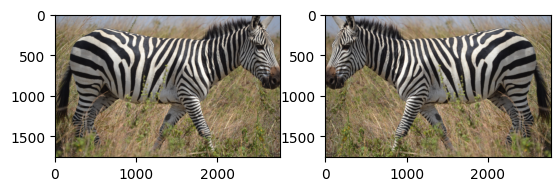

000000000428__xflipped.jpg
(986.1111111111111, 646.9907407407408, 1204.2824074074074, 946.7592592592592)


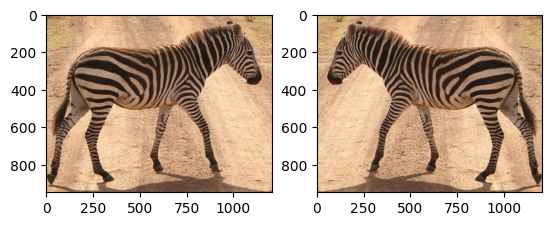

000000000390__xflipped.jpg
(1196.7592592592591, 775.4629629629629, 865.1620370370371, 750.0)


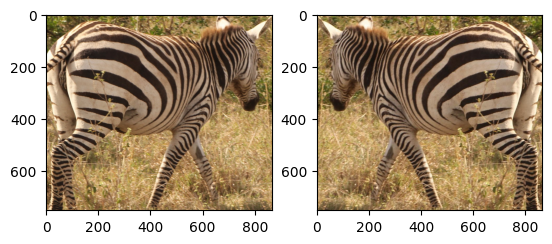

000000000394__xflipped.jpg
(2267.939814814815, 672.4537037037037, 715.2777777777778, 1045.138888888889)


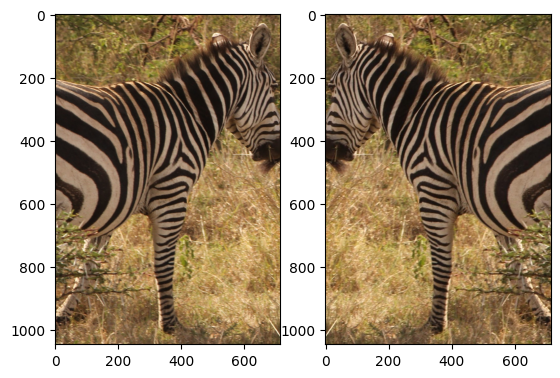

000000000394__xflipped.jpg
(1037.760416666667, 762.3697916666666, 432.29166666666663, 261.0677083333333)


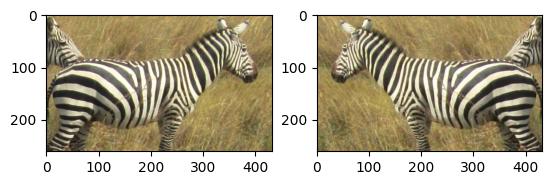

000000000412__xflipped.jpg
(1603.587962962963, 955.4398148148149, 351.27314814814815, 256.94444444444446)


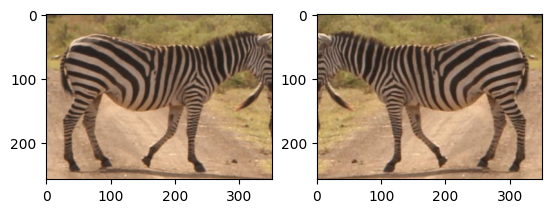

000000000384__xflipped.jpg
(1252.3148148148148, 852.4305555555555, 745.3703703703704, 424.18981481481484)


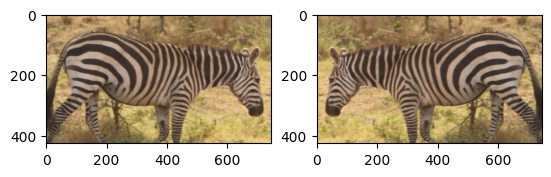

000000000388__xflipped.jpg
(1603.515625, 766.9270833333333, 1233.7239583333333, 647.1354166666666)


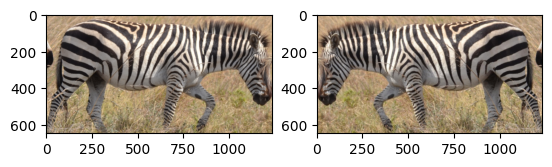

000000000431__xflipped.jpg
(638.8888888888887, 651.0416666666666, 1649.8842592592594, 1015.625)


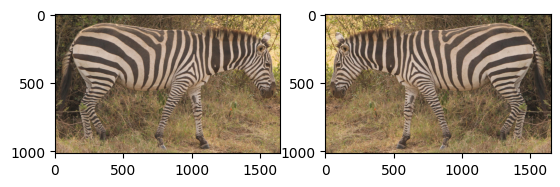

000000000392__xflipped.jpg
Annotations after flipping images: 957
viewpoint
left    957
dtype: int64


In [42]:
from PIL import Image
import os

def flip_image_and_bbox(image_path, bbox, file_path):
    # Open the image
    image = Image.open(image_path)
    
    # Flip the image horizontally (left to right)
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Save the flipped image with a new filename
    base_name, ext = os.path.splitext(file_path)
    flipped_file_path = f"{base_name}__xflipped{ext}"
    if not os.path.exists(flipped_file_path):
        flipped_image.save(flipped_file_path)

    # Update the bounding box: Flip the 'x' coordinates
    img_width = image.width
    x_min, y_min, w, h = bbox
    new_x_min = img_width - (x_min + w)  # Recalculate x_min for the flipped image
    
    # Return the updated bbox and new file path
    updated_bbox = (new_x_min, y_min, w, h)
    return updated_bbox, flipped_file_path

def to_PIL_bbox(bbox):
    return [*bbox[:2], bbox[2]+bbox[0], bbox[3]+bbox[1]]

# df = df[~df['file_name'].str.contains('flipped')]
# df = df.reset_index(drop=True)
df['path'] = df['file_name'].apply(lambda x: os.path.join(images_dir, x))
# df['bbox'] = df['bbox'].astype(object)
# Flip images and update bbox
for idx, row in df.iterrows():
    if row['viewpoint'] == 'right':  # Assuming 'left' is the viewpoint to flip
        image_path = row['path']
        bbox = row['bbox']  # Assuming bbox is stored as a tuple (x_min, y_min, x_max, y_max)
        updated_bbox, flipped_image_path = flip_image_and_bbox(image_path, bbox, image_path)

        print(updated_bbox)

        plt.subplot(121)
        plt.imshow(Image.open(image_path).crop(to_PIL_bbox(bbox)))
        plt.subplot(122)
        plt.imshow(Image.open(flipped_image_path).crop(to_PIL_bbox(updated_bbox)))
        plt.show()
        # Update the DataFrame with the new image path and bbox
        print(flipped_image_path.split('/')[-1])
        df.at[idx, 'file_name'] = flipped_image_path.split('/')[-1]
        for i in range(len(df.at[idx, 'bbox'] )):
            df.at[idx, 'bbox'][i] = int(updated_bbox[i])
        df.at[idx, 'viewpoint'] = 'left'  # Update viewpoint to 'right' after flipping

print("Annotations after flipping images:", len(df))

counts = df.groupby('viewpoint').size()
print(counts)

In [61]:
# data['bbox'] = data.apply(lambda row: [row['bbox x'], row['bbox y'], row['bbox w'], row['bbox h']], axis=1)
# data['file_name'] = data.apply(lambda row: row['file_path'].split('/')[-1], axis=1)

df = df.drop_duplicates(subset=['path', 'name_viewpoint'], keep=False)
len(df)


745

In [43]:
save_data(df, '/home/kate/data/plainZebra_giraffeID/gzgc.coco/annotations/preprocessed/plain_zebra_singletons_encounters_flipped_fixed.json')

Data is saved to: /home/kate/data/plainZebra_giraffeID/gzgc.coco/annotations/preprocessed/plain_zebra_singletons_encounters_flipped_fixed.json


index                                uuid_x  \
1277    480  84d83bf3-e88b-4702-ae6e-e6536686d731   
1304    507  34353f97-f1ce-4b45-913f-0edf0d6dd404   
512     512  131a4d6d-cf66-42e0-9607-7af2c246812a   
649     649  376ee34b-dc81-4e8e-828a-daa9ec27dfec   
482     482  4a51b74b-7aba-4700-af85-c2cd821eb77f   
...     ...                                   ...   
771     771  d8a69d29-a6ea-424d-a057-2ff11f076bb5   
1300    503  b0b4e055-49cb-46f9-8bb4-aebe38c895ea   
1314    517  ef96d9b2-f443-4c8e-9da8-02d0fc0302a2   
239     239  fef801e3-9cb4-4e24-aad4-93ed768b60a8   
11       11  de291fa2-8aed-4509-8133-0cae234b609e   

                                image_uuid  theta  \
1277  481afe8b-9441-4cbc-b302-d5137f838a4d    0.0   
1304  4648c253-7453-40fb-9eb0-f732dd0950e3    0.0   
512   38132b53-90d7-4235-ba4e-8207ba724c8f    0.0   
649   4c19e4ac-b4fa-43df-a54e-fbdec4fb7bd7    0.0   
482   ec7c7bab-b63d-4c97-a61f-2200869be3e1    0.0   
...                                    ...    ...   
771   b931be9f-8ce0-4632-9858-12dd3079a743    0.0   
1300  439b2930-46bc-4dc5-b281-9ceb1e38f6f7    0.0   
1314  762f9bef-92ea-44b0-8322-e55ee5df29a5    0.0   
239   ab438c0a-6996-4806-b8a6-d9af61db01b8    0.0   
11    fa834e3c-acbe-477d-90c2-1cb571ca966a    0.0   

                           individual_uuid  category_id           name  \
1277  f6821cf5-b775-44f7-8781-a377564e08a8            1  IBEIS_PZ_0002   
1304  f6821cf5-b775-44f7-8781-a377564e08a8            1  IBEIS_PZ_0002   
512   492bcad6-bd78-446d-be13-56c73f81660f            1  IBEIS_PZ_0003   
649   492bcad6-bd78-446d-be13-56c73f81660f            1  IBEIS_PZ_0003   
482   1bbb1769-219b-49da-9f0e-952e5c356379            1  IBEIS_PZ_0004   
...                                    ...          ...            ...   
771   a729ea4d-195d-4574-93bb-de80c54734d8            1  IBEIS_PZ_1906   
1300  d60e6222-43e0-4631-a1ce-861cd0701450            1  IBEIS_PZ_1907   
1314  d60e6222-43e0-4631-a1ce-861cd0701450            1  IBEIS_PZ_1907   
239   9bb68ec5-0335-415c-9037-11dd254b4599            1  IBEIS_PZ_1908   
11    9bb68ec5-0335-415c-9037-11dd254b4599            1  IBEIS_PZ_1908   

          name_viewpoint  species_viewpoint       species  ...  \
1277  IBEIS_PZ_0002-left  zebra_plains-left  zebra_plains  ...   
1304  IBEIS_PZ_0002-left  zebra_plains-left  zebra_plains  ...   
512   IBEIS_PZ_0003-left  zebra_plains-left  zebra_plains  ...   
649   IBEIS_PZ_0003-left  zebra_plains-left  zebra_plains  ...   
482   IBEIS_PZ_0004-left  zebra_plains-left  zebra_plains  ...   
...                  ...                ...           ...  ...   
771   IBEIS_PZ_1906-left  zebra_plains-left  zebra_plains  ...   
1300  IBEIS_PZ_1907-left  zebra_plains-left  zebra_plains  ...   
1314  IBEIS_PZ_1907-left  zebra_plains-left  zebra_plains  ...   
239   IBEIS_PZ_1908-left  zebra_plains-left  zebra_plains  ...   
11    IBEIS_PZ_1908-left  zebra_plains-left  zebra_plains  ...   

                                                   bbox         file_name  \
1277  [865.7296650717703, 803.8277511961722, 630.681...  000000003499.jpg   
1304    [465.8203125, 703.125, 884.765625, 817.3828125]  000000003619.jpg   
512    [1362.3046875, 436.5234375, 656.25, 717.7734375]  000000003615.jpg   
649   [1954.3539325842698, 602.5280898876405, 1032.3...  000000004212.jpg   
482   [2084.9282296650717, 1124.102870813397, 170.45...  000000003477.jpg   
...                                                 ...               ...   
771   [2188.9044943820227, 761.2359550561798, 735.95...  000000004787.jpg   
1300  [1709.9282296650717, 1089.1148325358852, 385.7...  000000003591.jpg   
1314  [752.9296875, 583.0078125, 1523.4375, 1201.171...  000000003670.jpg   
239                      [150.0, 261.0, 2280.0, 1075.5]  000000001866.jpg   
11               [171.875, 237.5, 2432.8125, 1667.1875]  000000000070.jpg   

     height  width        date_captured                                uuid_y  \
1277   1995   3000  2015-02-18 19:27:11  481

In [2]:
from preprocess import preprocess, compute_dataset_statistics, save_data
from tools import read_yaml_config

config_file_path = 'configs/config_kate.yaml'
species = 'zebra_plain'
config = read_yaml_config(config_file_path, species)
print(config)

anno_path = config["preprocessed_annotation_path"]


images_dir = config["images_dir"]
csv_dir = config['csv_dir']
csv_column_names = config['csv_column_names']
merge_cols = config['merge_cols']
output_path = config['preprocessed_annotation_path']

data=preprocess(anno_path, images_dir, csv_dir, csv_column_names, merge_cols)
compute_dataset_statistics(data)


{'data_dir': '/home/kate/data/plainZebra_giraffeID/gzgc.coco', 'export_dir': '/home/kate/data/plainZebra_giraffeID/gzgc.coco/annotations/split', 'images_dir': '/home/kate/data/plainZebra_giraffeID/gzgc.coco/images/train2020', 'raw_annotation_path': '/home/kate/data/plainZebra_giraffeID/gzgc.coco/annotations/instances_train2020.json', 'preprocessed_annotation_path': '/home/kate/data/plainZebra_giraffeID/gzgc.coco/annotations/preprocessed/plain_zebra.json', 'excluded_viewpoints': ['back', 'backleft', 'bckright', 'front', 'frontleft', 'frontright'], 'csv_dir': 'None', 'csv_column_names': 'None', 'merge_cols': 'None'}
Merging on image uuid


KeyError: 'name_category'